# Turkish Wikipedia, ORES baseline

- dataset: `trwiki`
- models: _[ORES](https://ores.wikimedia.org/) damaging & reverted_

This notebook computes statistics of the ORES predictors.

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.metrics import (
    precision_recall_curve, average_precision_score)
from interank.wikidata import WikiData

%matplotlib inline

## Processing the raw data

In [2]:
dataset = WikiData("/data/datasets/trwiki")
raw = dataset.get_raw_test_data()

In [3]:
revid2q = dict(zip(raw[0], (raw[4] + 1) / 2))

In [4]:
y_pred_r = list()
y_pred_d = list()
labels = list()

revids = set(raw[0])
n_errors = 0
with open("/data/datasets/trwiki/ores.txt") as f:
    for line in f:
        scores = json.loads(line.strip())
        for revid, obj in scores.items():
            revid = int(revid)
            if revid not in revids:
                # The edit is actually not in the test set.
                continue
            if "score" not in obj["reverted"]:
                n_errors += 1
                continue
            y_pred_r.append(obj["reverted"]["score"]["probability"]["true"])
            y_pred_d.append(obj["damaging"]["score"]["probability"]["true"])
            labels.append(revid2q[revid])

labels = np.array(labels)
y_pred_r = np.array(y_pred_r)
y_pred_d = np.array(y_pred_d)

print("Number of edits: {:,}".format(len(labels)))
print("Number of errors: {:,}".format(n_errors))

Number of edits: 527,281
Number of errors: 4,806


## Precision-recall plot

In [5]:
y_true = (labels < 0.5).astype(int)
print("proportion of positive labels: {:.3f}".format(y_true.mean()))

proportion of positive labels: 0.165


In [6]:
prec_r, rec_r, _ = precision_recall_curve(y_true, y_pred_r)
auc_r = average_precision_score(y_true, y_pred_r)

prec_d, rec_d, _ = precision_recall_curve(y_true, y_pred_d)
auc_d = average_precision_score(y_true, y_pred_d)

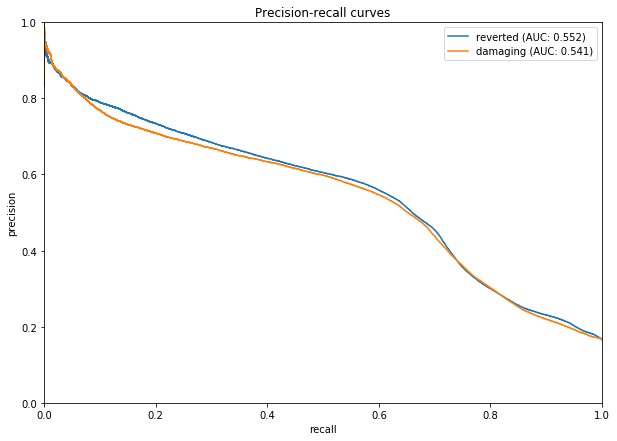

In [7]:
fig, ax = plt.subplots(figsize=(10.0, 7.0))
ax.plot(rec_r, prec_r, label="reverted (AUC: {:.3f})".format(auc_r))
ax.plot(rec_d, prec_d, label="damaging (AUC: {:.3f})".format(auc_d))
ax.set_xlim(xmin=0.0, xmax=1.0)
ax.set_ylim(ymin=0.0, ymax=1.0)
ax.set_ylabel("precision")
ax.set_xlabel("recall")
ax.set_title("Precision-recall curves")
ax.legend()

Compute the average log-loss

In [8]:
def avg_log_loss(y_true, y_pred):
    log_loss = - (y_true * np.log(y_pred)
            + (1 - y_true) * np.log(1 - y_pred))
    return log_loss.mean()

In [9]:
val = avg_log_loss(1 - labels, y_pred_r)
print("average log-loss: {:.4f}".format(val))

average log-loss: 0.4656


## Save data for plotting, etc.

In [10]:
data_r = {
    "y_true": labels,
    "y_pred": y_pred_r,
}
with open("../data/trwiki-ores-reverted-pred.pickle", "wb") as f:
    pickle.dump(data_r, f)
    
data_d = {
    "y_true": labels,
    "y_pred": y_pred_d,
}
with open("../data/trwiki-ores-damaging-pred.pickle", "wb") as f:
    pickle.dump(data_d, f)